In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

plt.style.use('seaborn-colorblind')
%matplotlib inline

# грязный хак от надоедливых предупреждений
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("./creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

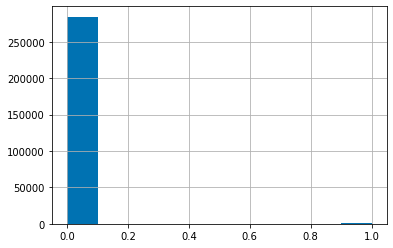

In [4]:
data["Class"].hist()

In [5]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [6]:
print('Frauds', round(data['Class'].value_counts()[1]/len(data) * 100,2), '% of the dataset')
print('No Frauds', round(data['Class'].value_counts()[0]/len(data) * 100,2), '% of the dataset')

Frauds 0.17 % of the dataset
No Frauds 99.83 % of the dataset


In [7]:
fraud_df = data.loc[data["Class"] == 1]
fraud_df["Class"].value_counts()

1    492
Name: Class, dtype: int64

In [8]:
non_fraud_df = data.loc[data["Class"] == 0].sample(frac=1, random_state=42)[:492]
non_fraud_df["Class"].value_counts()

0    492
Name: Class, dtype: int64

In [9]:
new_df = pd.concat([fraud_df, non_fraud_df]).sample(frac=1)
new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
204503,135314.0,-3.158990,1.765452,-3.390168,0.987410,-1.509930,-1.280952,-2.719557,0.718325,-1.660183,...,1.120533,1.605085,-0.618637,-0.251283,-0.240528,-0.004327,-0.235477,0.018129,84.28,1
123201,76845.0,1.141572,1.291195,-1.432900,2.058202,0.940824,-0.958274,0.391154,-0.092519,-0.032829,...,-0.366507,-0.714465,-0.143911,-0.305178,0.697514,-0.312545,0.106247,0.125060,1.00,1
29005,35273.0,-8.313402,-6.270720,-1.333801,0.218199,-1.101031,-0.327100,-0.677812,1.073467,-0.625128,...,-0.107142,0.310856,-1.415962,-0.043644,0.226258,-0.278381,-0.411807,-0.289386,84.00,0
229712,146022.0,0.908637,2.849024,-5.647343,6.009415,0.216656,-2.397014,-1.819308,0.338527,-2.819883,...,0.407260,-0.397435,-0.080006,-0.168597,0.465058,0.210510,0.648705,0.360224,1.18,1
17317,28625.0,-27.848181,15.598193,-28.923756,6.418442,-20.346228,-4.828202,-19.210896,18.329406,-3.668735,...,1.802149,-2.062934,-1.269843,0.165409,1.999499,-0.211059,1.324809,0.388090,99.99,1


In [10]:
new_df['Class'].value_counts()

1    492
0    492
Name: Class, dtype: int64

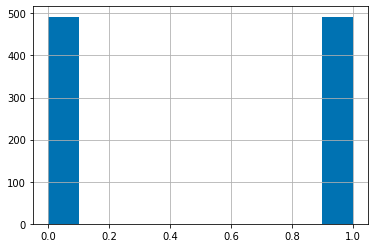

In [11]:
new_df["Class"].hist()

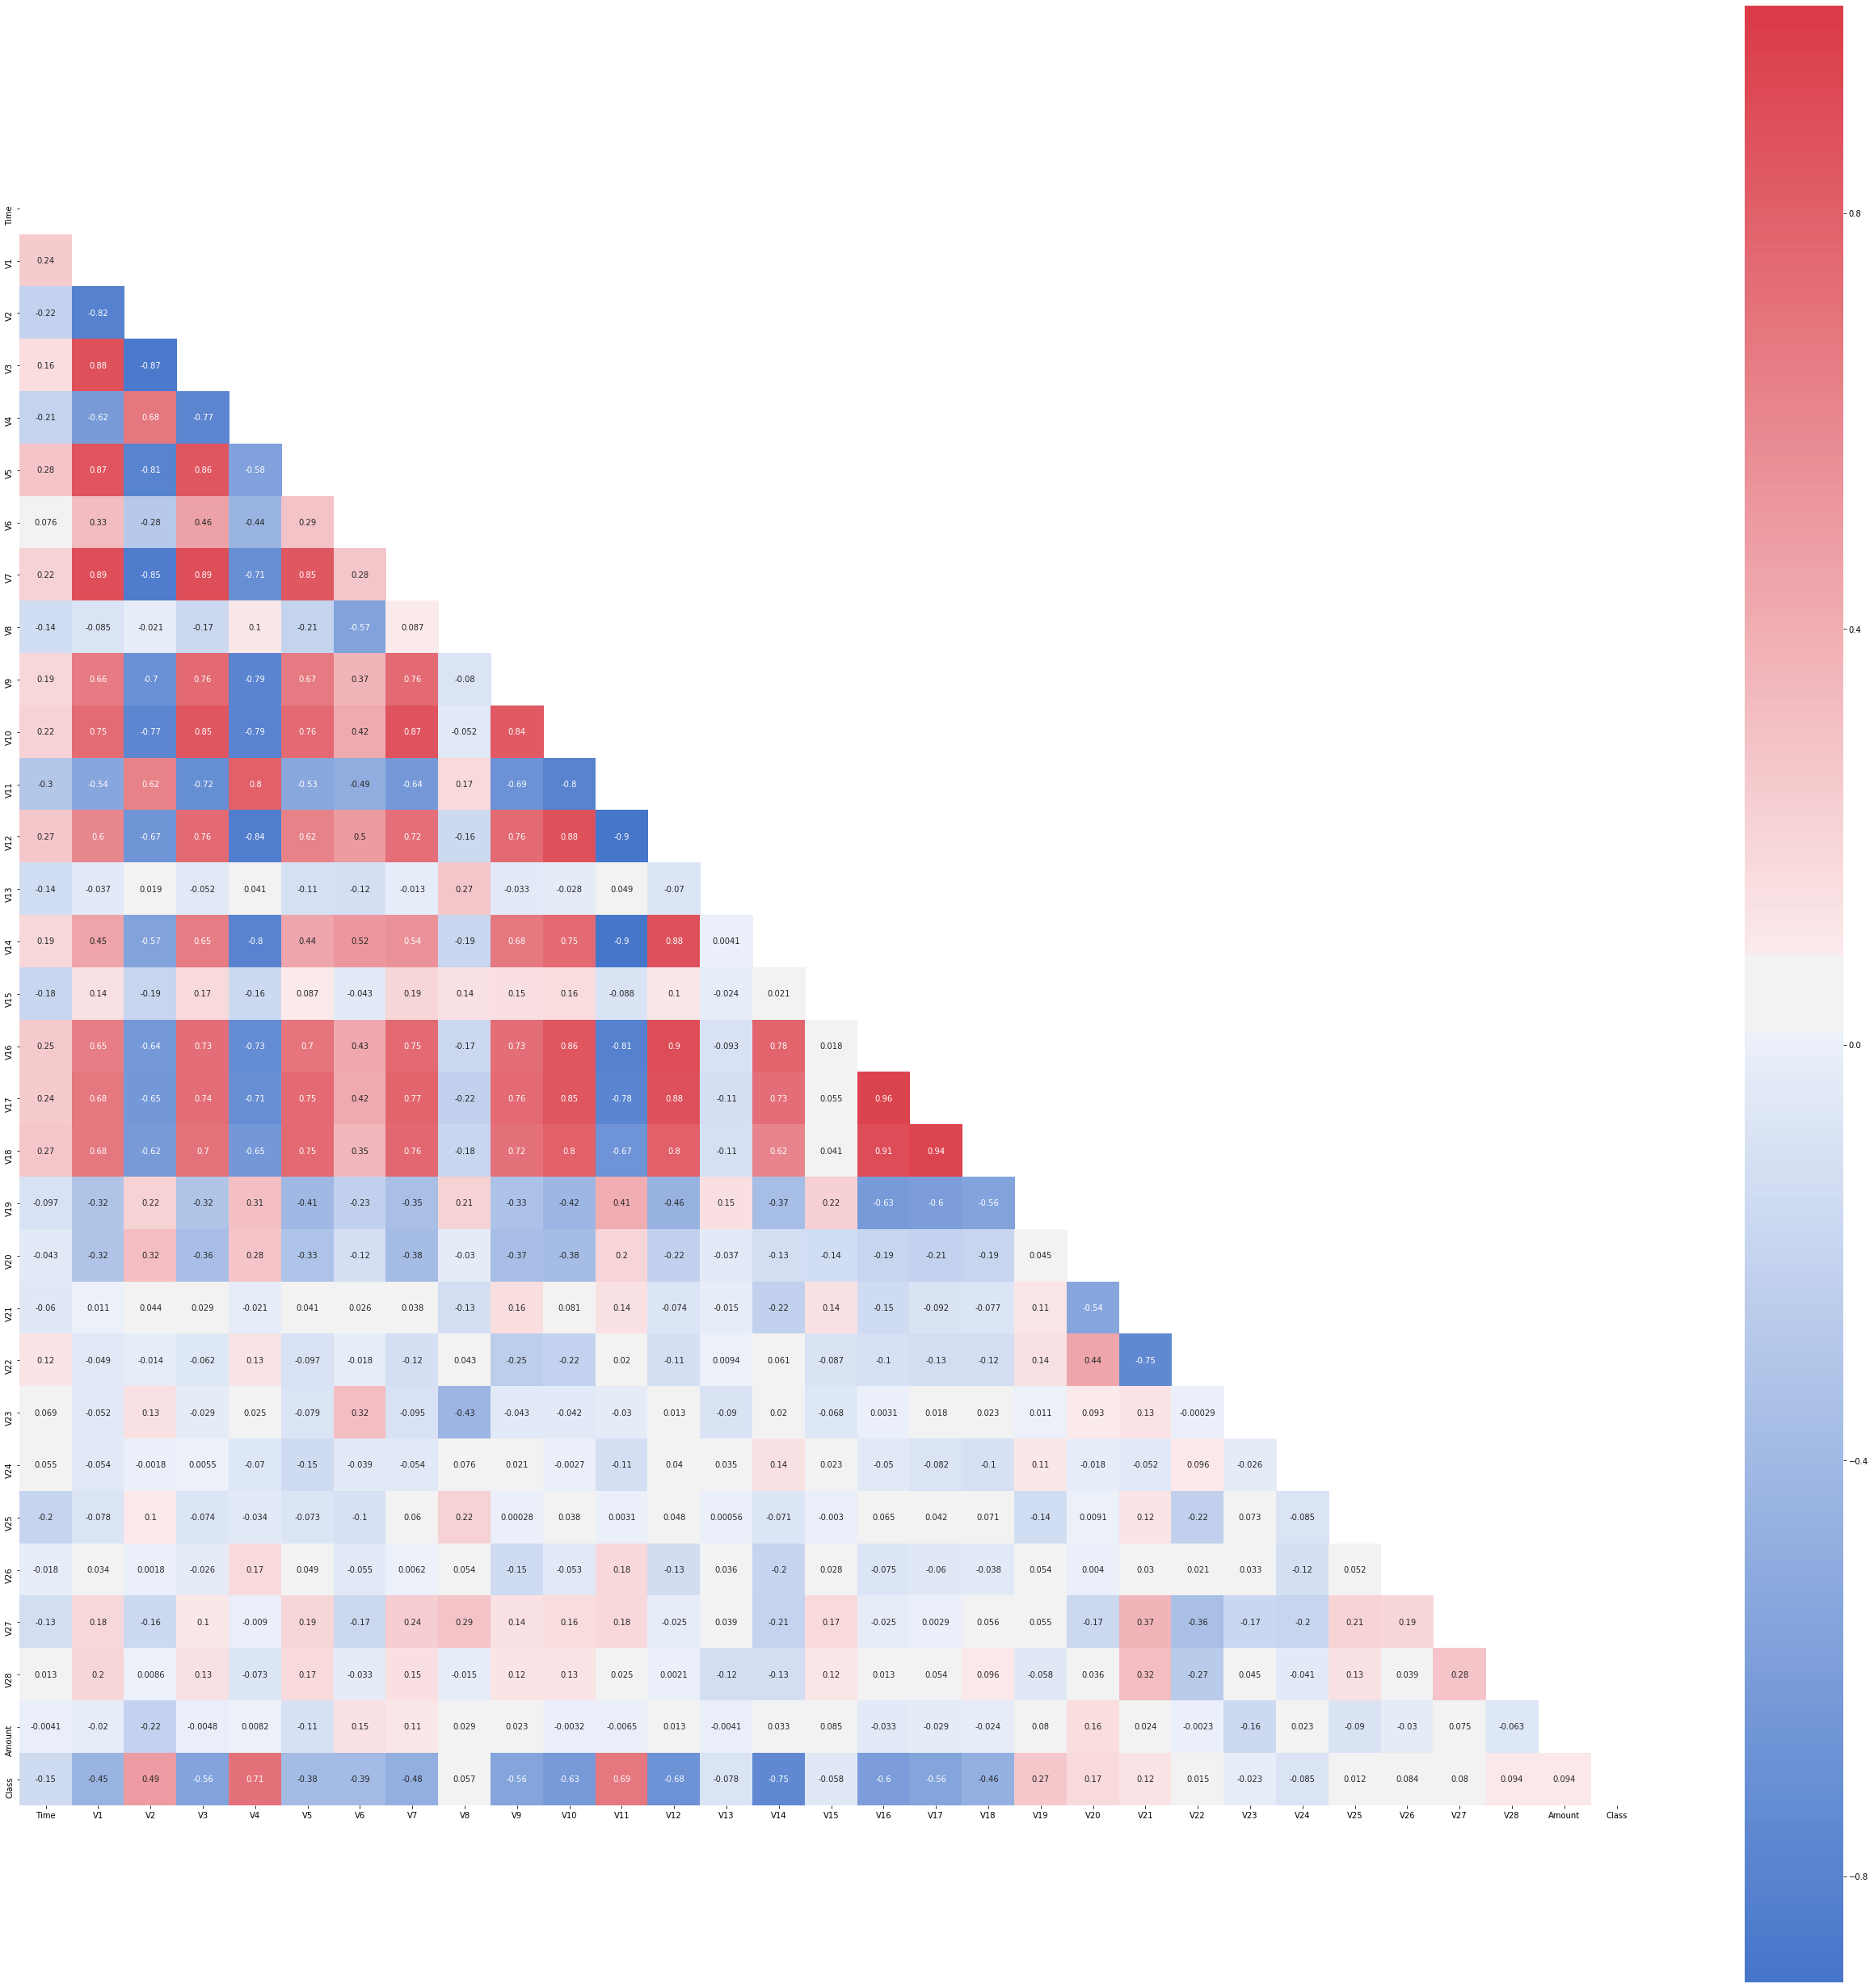

In [12]:
plt.figure(figsize = (45,45))
mask = np.zeros_like(new_df.corr())
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(255, 10, as_cmap = True)
sns.heatmap(\
            new_df.corr(), \
            annot = True, \
            square = True, \
            mask = mask, \
            cmap = cmap \
).get_figure().savefig("correlations_big_picture.png");

In [13]:
# Классы сбалансировали, для деревьев бОльшего не надо.
# Построим первое дерево, возьмем его за baseline:

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

import pydot
import sklearn
import seaborn as sns
from graphviz import Source

import seaborn as sns

def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))
    

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    new_df.drop(["Class"], axis=1), 
    new_df["Class"], 
    test_size=0.20, # 20% на тесты 
    random_state=42, # любой id для воспроизводимой рандомности в рамках одного окружения
    stratify=new_df["Class"] # бьем чтобы в тест попало пропорциональное число с True/False
)


In [15]:
print(y_train.value_counts(normalize=True))
print(y_train.value_counts(normalize=False))


1    0.500635
0    0.499365
Name: Class, dtype: float64
1    394
0    393
Name: Class, dtype: int64


In [16]:
print(y_test.value_counts(normalize=True))
print(y_test.value_counts(normalize=False))


0    0.502538
1    0.497462
Name: Class, dtype: float64
0    99
1    98
Name: Class, dtype: int64


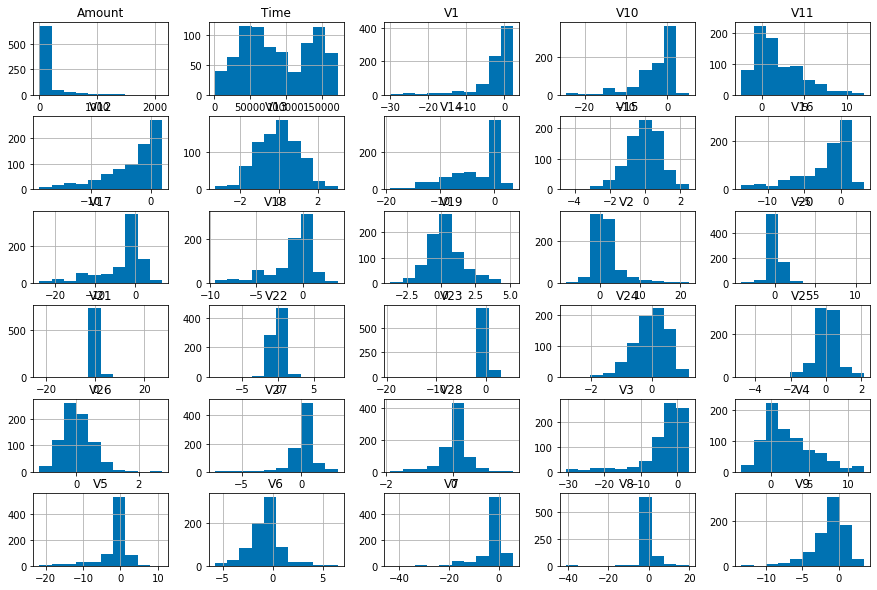

In [17]:
# посмотрим на шистограммы, но заниматься ими не будем
X_train.hist(figsize=(15, 10));

Accuracy: 0.508
Precision: 0.541
Recall: 0.505
f1_score: 0.522


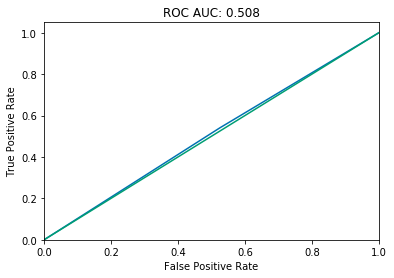

In [18]:
# делаем наивное предсказание, хуже которого быть не может:
y_naive = np.random.choice([0, 1], size=y_test.shape[0], p=y_train.value_counts(normalize=True))

quality_report(y_naive, y_test)

plot_roc_curve(y_naive, y_test)

In [19]:
# Теперь первое дерево, без настройки параметров:

first_tree = DecisionTreeClassifier(max_depth=3, random_state=42)
first_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

Train quality
Accuracy: 0.945
Precision: 0.909
Recall: 0.981
f1_score: 0.943

Test quality
Accuracy: 0.944
Precision: 0.898
Recall: 0.989
f1_score: 0.941


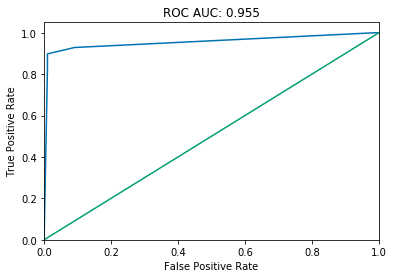

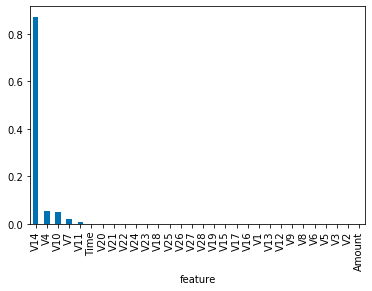

In [20]:
# и быстренько посмотрим на статистики полученной модели

print("Train quality")
quality_report(first_tree.predict(X_train), y_train)

print("\nTest quality")
quality_report(first_tree.predict(X_test), y_test)

plot_roc_curve(first_tree.predict_proba(X_test)[:, 1], y_test)

featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": first_tree.feature_importances_})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar');

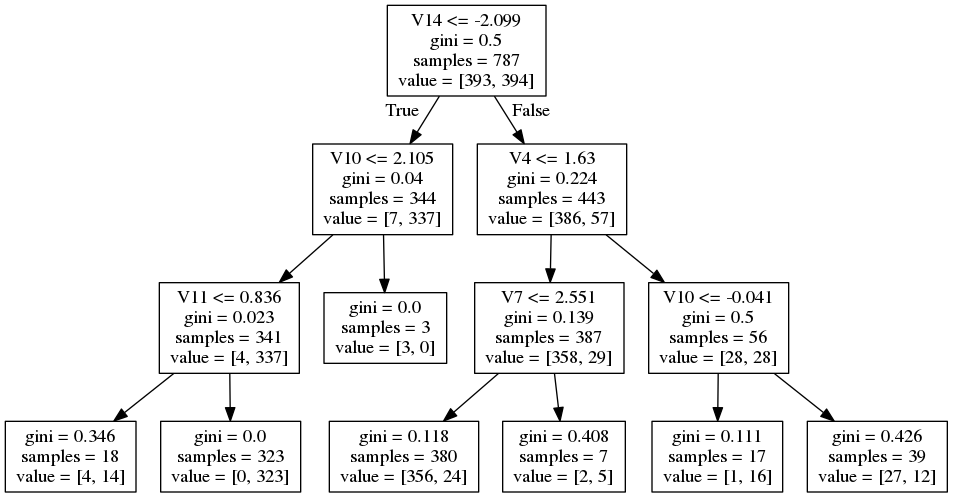

In [21]:
# и специфично для деревьев - само дерево:
# sudo apt-get install graphviz

graph = Source(sklearn.tree.export_graphviz(first_tree, out_file=None, feature_names=X_train.columns))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

In [22]:
# Ok, теперь GridSearch деревом по тем же данным:
from sklearn.model_selection import GridSearchCV, train_test_split

tree_params = {
               'max_depth': list(range(3,11)), 
               'min_samples_leaf': list(range(3,11)),
               'class_weight': [None, 'balanced']
}

locally_best_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), 
                                 tree_params, 
                                 verbose=True, n_jobs=-1, cv=5,
                                scoring='roc_auc')
locally_best_tree.fit(X_train, y_train)

locally_best_tree.best_params_, round(locally_best_tree.best_score_, 3)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 640 out of 640 | elapsed:    6.0s finished


({'class_weight': None, 'max_depth': 6, 'min_samples_leaf': 8}, 0.954)

Train quality
Accuracy: 0.953
Precision: 0.934
Recall: 0.971
f1_score: 0.952

Test quality
Accuracy: 0.914
Precision: 0.888
Recall: 0.935
f1_score: 0.911


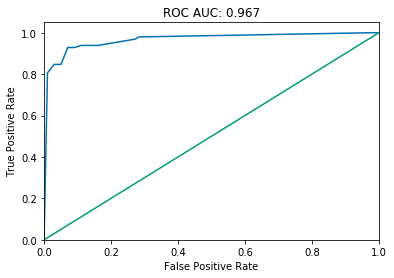

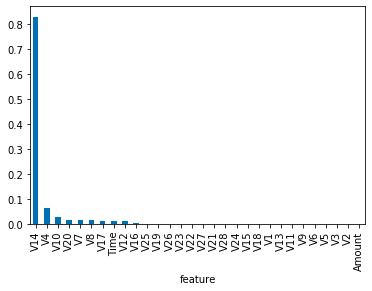

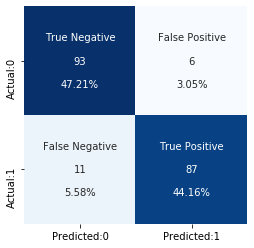

In [23]:
# Train quality
print("Train quality")
quality_report(locally_best_tree.predict(X_train), y_train)

# Test quality
print("\nTest quality")
quality_report(locally_best_tree.predict(X_test), y_test)

# ROC_AUC curve 
plot_roc_curve(locally_best_tree.predict_proba(X_test)[:, 1], y_test)

# feature importancies
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": locally_best_tree.best_estimator_.feature_importances_})
featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar');

# confusion matrix
cm = confusion_matrix(y_test, locally_best_tree.predict(X_test))
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.values.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.values.flatten()/np.sum(conf_matrix.values)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (4,4))
cmap = "Blues"
sns.heatmap(conf_matrix, annot=labels,fmt='',cmap=cmap, cbar=False);

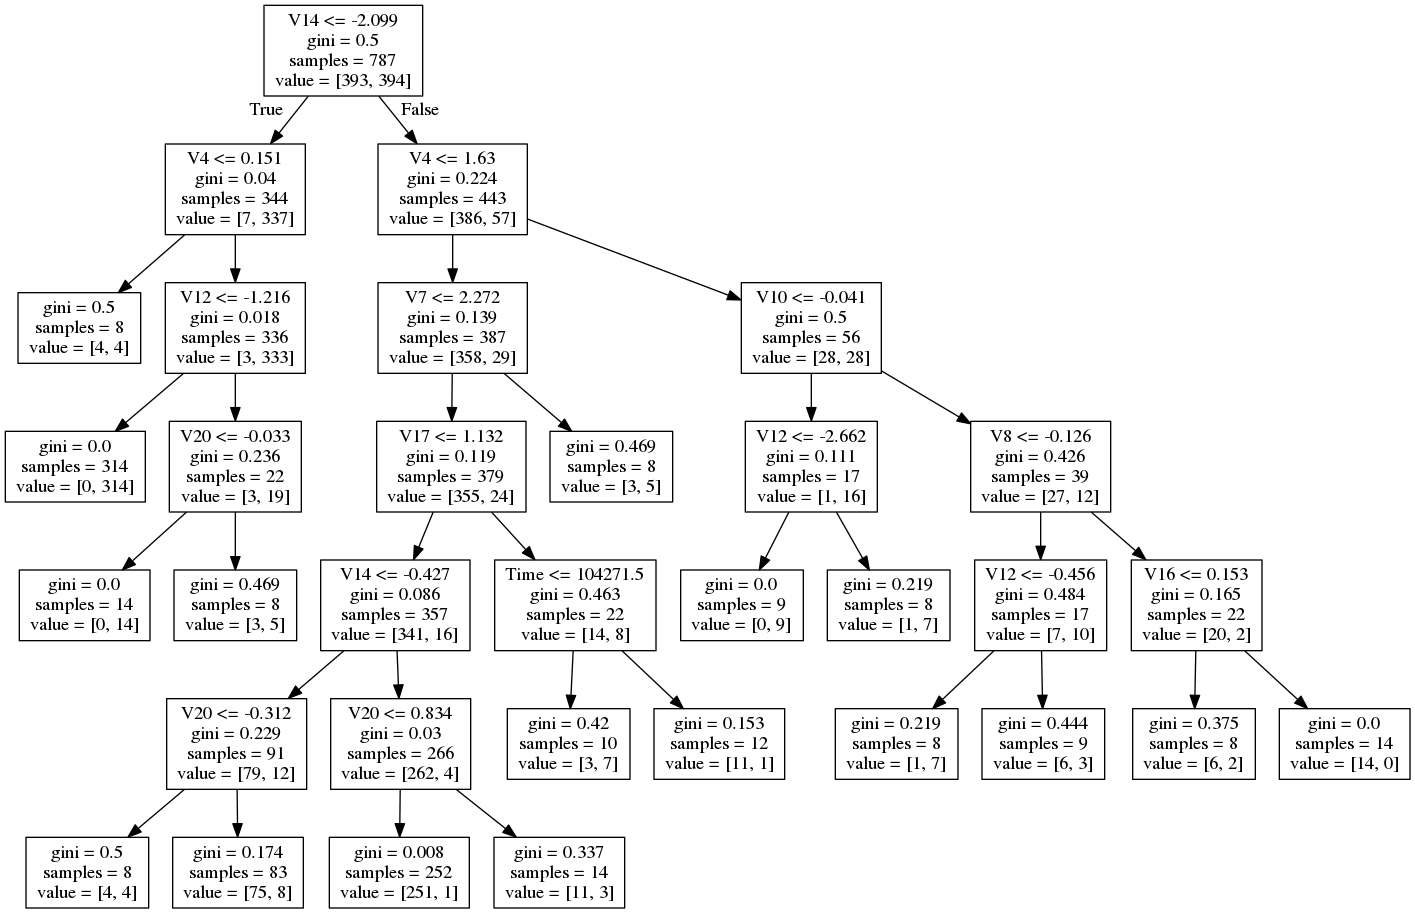

In [24]:
# и специфично для деревьев - само дерево:
# sudo apt-get install graphviz

graph = Source(sklearn.tree.export_graphviz(locally_best_tree.best_estimator_, out_file=None, feature_names=X_train.columns))
png_bytes = graph.pipe(format='png')
with open('dtree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

In [25]:
# Ok, гридом подобрали наилучшие параметры одного дерева.
# Теперь поюзаем wisdom of crowd и вырастим лес. 
# Посмотрим как разные деревья будут выбирать лучший ответ.

In [26]:
# Но для начала вспомним и посмотрим как себя ведет hard voting 
# (классификация, для регрессии = soft voting), если у нас есть разные модели
# и хотим получать ответ по согласию нескольких моделей:

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.9238578680203046
RandomForestClassifier 0.9238578680203046
SVC 0.5482233502538071
VotingClassifier 0.9289340101522843


In [27]:
# видно что модели сильно разные, и на одном и том же наборе данных работают сильно по-разному
# посмотрим на VotingClassifier: 

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV

clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft')

params = {'lr__C': [1.0, 100.0], 'rf__n_estimators': [20, 200],}

grid = GridSearchCV(estimator=eclf, param_grid=params, cv=5)

grid = grid.fit(X_train, y_train)
grid.best_estimator_

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=1, solver='warn',
                                                 tol=0.0001, verbose=0,
                                                 warm_start=False)),
                             ('rf',
                              RandomForestClassifier(bootstrap=True,
                                                     class_weight=None,
                                                     criterion='gini',
                                              

In [28]:
# берем RandomForest и тюним: подбор параметров, bagging / stacking
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

Train quality
Accuracy: 0.972
Precision: 0.947
Recall: 0.997
f1_score: 0.971

Test quality
Accuracy: 0.929
Precision: 0.888
Recall: 0.967
f1_score: 0.926


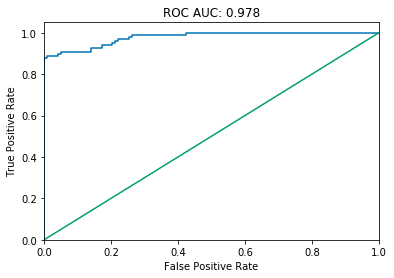

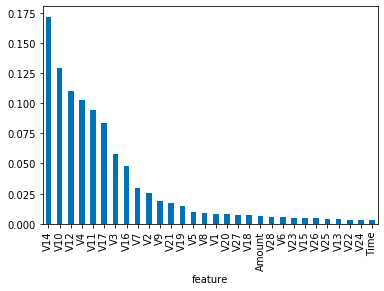

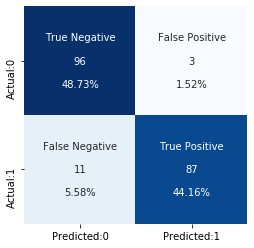

In [29]:
# Train quality
print("Train quality")
quality_report(rnd_clf.predict(X_train), y_train)

# Test quality
print("\nTest quality")
quality_report(rnd_clf.predict(X_test), y_test)

# ROC_AUC curve 
plot_roc_curve(rnd_clf.predict_proba(X_test)[:, 1], y_test)

# feature importancies
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": rnd_clf.feature_importances_})
featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar');

# confusion matrix
cm = confusion_matrix(y_test, rnd_clf.predict(X_test))
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.values.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.values.flatten()/np.sum(conf_matrix.values)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (4,4))
cmap = "Blues"
sns.heatmap(conf_matrix, annot=labels,fmt='',cmap=cmap, cbar=False);

In [30]:
# Not bad, посмотрим что даст bagging на RandomForest:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    RandomForestClassifier(max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)


BaggingClassifier(base_estimator=RandomForestClassifier(bootstrap=True,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features='auto',
                                                        max_leaf_nodes=16,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        n_estimators='warn',
                                                        n_jobs=None,
      

Train quality
Accuracy: 0.967
Precision: 0.937
Recall: 0.997
f1_score: 0.966

Test quality
Accuracy: 0.929
Precision: 0.888
Recall: 0.967
f1_score: 0.926


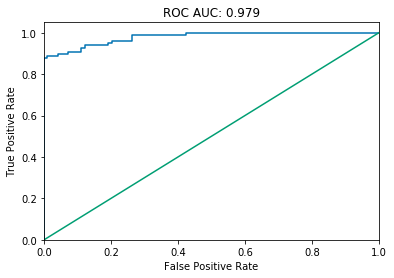

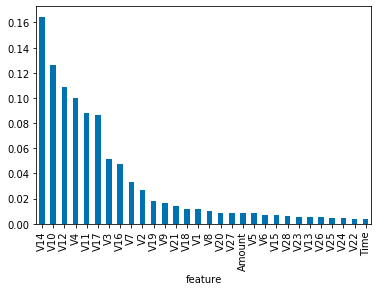

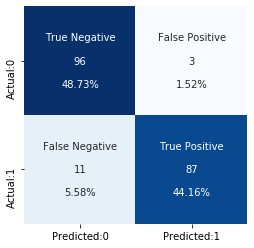

In [31]:
# Train quality
print("Train quality")
quality_report(bag_clf.predict(X_train), y_train)

# Test quality
print("\nTest quality")
quality_report(bag_clf.predict(X_test), y_test)

# ROC_AUC curve 
plot_roc_curve(bag_clf.predict_proba(X_test)[:, 1], y_test)

# feature importancies !!! Special for bagging !!!
forest_feature_importances = np.mean([
    tree.feature_importances_ for tree in bag_clf.estimators_
], axis=0) # сначала надо посчитать средний вес каждого параметра по каждому дереву в лесу
featureImportance = pd.DataFrame({"feature": X_train.columns, 
                                  "importance": forest_feature_importances})
featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar');

# confusion matrix
cm = confusion_matrix(y_test, bag_clf.predict(X_test))
conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
group_names = ['True Negative','False Positive','False Negative','True Positive']
group_counts = ["{0:0.0f}".format(value) for value in conf_matrix.values.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in conf_matrix.values.flatten()/np.sum(conf_matrix.values)]
labels = [f"{v1}\n\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.figure(figsize = (4,4))
cmap = "Blues"
sns.heatmap(conf_matrix, annot=labels,fmt='',cmap=cmap, cbar=False);

In [32]:
# Бэггинг ничего не дал в нашем случае. Бывает.
# Зато RandomForest явно лучше чем DesicionTree.